# Variables

In [ ]:
image_dir = "/content/train/images"
label_dir = "/content/train/labels"
train_json_path = "/content/train/train_data.json"

class_map = {"car": 0, "traffic sign": 1, "pedestrian": 2}

# Add Label Folder for Train

In [ ]:
import os
import cv2
import json

os.makedirs(label_dir, exist_ok=True)

with open(train_json_path, 'r') as f:
    data = json.load(f)

for item in data:
    image_name = item["name"]
    label_lines = []

    if "labels" not in item or not item["labels"]:
        continue

    for label in item["labels"]:
        category = label.get("category")
        if category not in class_map:
          continue

        cls_id = class_map[category]
        box = label["box2d"]
        x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]

        image_path = os.path.join(image_dir, image_name)
        image = cv2.imread(image_path)

        if image is None:
          continue

        img_height, img_width = image.shape[:2]

        box_width = x2 - x1
        box_height = y2 - y1

        x_center = ((x1 + x2) / 2)
        y_center = ((y1 + y2) / 2)

        x_center_norm = x_center / img_width
        y_center_norm = y_center / img_height
        box_width_norm = box_width / img_width
        box_height_norm = box_height / img_height

        label_lines.append(f"{cls_id} {x_center_norm:.6f} {y_center_norm:.6f} {box_width_norm:.6f} {box_height_norm:.6f}")

    label_file = os.path.join(label_dir, image_name.replace(".jpg", ".txt"))
    with open(label_file, "w") as f:
        f.write("\n".join(label_lines))


# Split Validation and Train

## Generate Dataset Folder for Yolo Format

### Format




```
dataset/
├── images/
│   ├── train/
│   │   ├── image1.jpg
│   │   └── image2.jpg
│   └── val/
│       └── image3.jpg
├── labels/
│   ├── train/
│   │   ├── image1.txt
│   │   └── image2.txt
│   └── val/
│       └── image3.txt
```

### Generate Folders If Not Exist

In [ ]:
import os
import random
import shutil

In [ ]:
base_path = "/content/dataset"
for split in ["train", "val"]:
    os.makedirs(f"{base_path}/images/{split}", exist_ok=True)
    os.makedirs(f"{base_path}/labels/{split}", exist_ok=True)

## Shuffle and Split Dataset

In [ ]:
def move_files(file_list, split):
    for img_file in file_list:
        label_file = img_file.replace(".jpg", ".txt")

        shutil.copy(os.path.join(image_dir, img_file), os.path.join(base_path, "images", split, img_file))
        shutil.copy(os.path.join(label_dir, label_file), os.path.join(base_path, "labels", split, label_file))

In [ ]:
split_ratio = 0.8

In [ ]:
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

valid_image_files = []
for img_file in image_files:
    label_file = img_file.replace(".jpg", ".txt")
    if os.path.exists(os.path.join(label_dir, label_file)):
        valid_image_files.append(img_file)

random.seed(42)
random.shuffle(image_files)

split_idx = int(split_ratio * len(valid_image_files))
train_files = valid_image_files[:split_idx]
val_files = valid_image_files[split_idx:]

move_files(train_files, "train")
move_files(val_files, "val")

print(f"Total {len(train_files)} train, {len(val_files)} valid.")


Toplam 7702 train, 1926 valid görsel kopyalandı.


# Data Agumentation


In [ ]:
import albumentations as A

image_dir = "/content/dataset/images/train"
label_dir = "/content/dataset/labels/train"
output_image_dir = "/content/dataset/images/train"
output_label_dir = "/content/dataset/labels/train"

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.RandomScale(scale_limit=0.2, p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=10, p=0.3),
    A.Blur(blur_limit=3, p=0.3),
    A.RandomGamma(p=0.3),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.3))

In [ ]:
def load_yolo_labels(label_path):
  bboxes = []
  class_labels = []

  if not os.path.exists(label_path):
    return bboxes, class_labels

  with open(label_path, 'r') as f:

    for line in f.readlines():

      parts = line.strip().split()
      if len(parts) != 5:
        continue

      class_id = int(parts[0])
      bbox = list(map(float, parts[1:]))
      bboxes.append(bbox)
      class_labels.append(class_id)

  return bboxes, class_labels


In [ ]:
def save_yolo_labels(output_path, bboxes, class_labels):
    with open(output_path, 'w') as f:
        for label, box in zip(class_labels, bboxes):
            f.write(f"{int(label)} {' '.join(f'{x:.6f}' for x in box)}\n")


In [ ]:
from tqdm import tqdm

for img_file in tqdm(os.listdir(image_dir)):
  if not img_file.endswith(".jpg"):
      continue

  img_path = os.path.join(image_dir, img_file)
  label_path = os.path.join(label_dir, img_file.replace(".jpg", ".txt"))
  image = cv2.imread(img_path)
  height, width = image.shape[:2]
  bboxes, class_labels = load_yolo_labels(label_path)

  for i in range(5):
    try:
      transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
    except:
      continue

    aug_img = transformed["image"]
    aug_bboxes = transformed["bboxes"]
    aug_labels = transformed["class_labels"]

    car_count = aug_labels.count(0)
    traffic_sign_count = aug_labels.count(1)
    pedestrian_count = aug_labels.count(2)

    if len(aug_bboxes) == 0 or car_count >= (traffic_sign_count + pedestrian_count):
      continue

    aug_img_name = f"{img_file[:-4]}_aug{i}.jpg"
    cv2.imwrite(os.path.join(output_image_dir, aug_img_name), aug_img)

    aug_label_name = f"{img_file[:-4]}_aug{i}.txt"
    save_yolo_labels(os.path.join(output_label_dir, aug_label_name), aug_bboxes, aug_labels)

100%|██████████| 7702/7702 [03:40<00:00, 34.86it/s]


In [ ]:
import os
from collections import Counter
import matplotlib.pyplot as plt

def create_yolo_label_histogram(folder_path):
    label_counts = Counter()

    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if parts:
                        label = int(parts[0])
                        label_counts[label] += 1

    labels = sorted(label_counts.keys())
    counts = [label_counts[label] for label in labels]

    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts)
    plt.xlabel('Label ID')
    plt.ylabel('Count')
    plt.title('YOLO Label Histogram')
    plt.xticks(labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print(counts)

[82096, 36664, 21516]


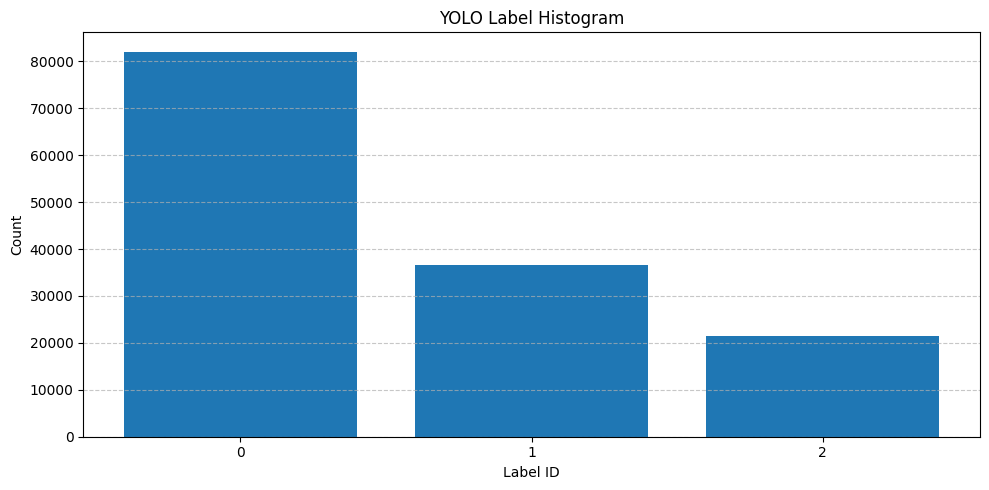

In [ ]:
create_yolo_label_histogram('/content/dataset/labels/train')

# Generate Yaml File For Yolo

In [ ]:
data_yaml = """
train: /content/dataset/images/train
val: /content/dataset/images/val

nc: 3
names:
  0: car
  1: traffic sign
  2: pedestrian
"""

with open("data.yaml", "w") as f:
    f.write(data_yaml)

# Define Yolo Model

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8m.pt")

100%|██████████| 49.7M/49.7M [00:00<00:00, 180MB/s]


# Train Model

In [ ]:
model.train(
    data="/content/data.yaml",
    epochs=100,
    patience=10,
    imgsz=640,
    batch=32,
    device=0,
    lr0=0.001,
    optimizer="Adam",
    save_period=10,
    val=True,
    workers=2
)

# Get Trained Model

In [ ]:
model = YOLO("/content/runs/detect/train/weights/best.pt")

In [ ]:
from glob import glob

image_paths = glob("/content/test/images/*.jpg")

# Load Empty Submission CSV File In Drive

In [ ]:
import cv2
import os
from google.colab import drive
import pandas as pd
import numpy as np
from tqdm import tqdm

file_name = "test_empty_submission_spring25.csv"
file_path = os.path.join("/content/drive/MyDrive/MTH 423", file_name)

drive.mount('/content/drive')
!cp "/content/drive/MyDrive/MTH 423/test_empty_submission_spring25.csv" "/content/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Give Test Image to Model And Save Result in CSV File

## Define Parameters

In [ ]:
image_folder_path = "/content/test/images"
class_list = ['car', 'traffic sign', 'pedestrian']
threshold = 0.25

## Define Submission File

In [ ]:
submission_template = pd.read_csv('test_empty_submission_spring25.csv')

my_submission = submission_template.copy()

my_submission[['x1', 'y1', 'x2', 'y2']] = my_submission[['x1', 'y1', 'x2', 'y2']].astype(float)

image_names = pd.unique(my_submission['img_name']).tolist()

my_submission.set_index('ID', inplace=True)

## Run Model to Whole Test Dataset Then Save Results

In [ ]:
from tqdm import tqdm
import cv2
import os

for img_name in tqdm(image_names):
    pred_rows = my_submission[my_submission['img_name'] == img_name]
    prediction_number = len(pred_rows)

    img_path = os.path.join(image_folder_path, img_name)
    image = cv2.imread(img_path)
    height, width = image.shape[:2]

    results = model(img_path, conf=threshold)
    boxes = results[0].boxes
    sorted_boxes = sorted(boxes, key=lambda box: float(box.conf[0]), reverse=True)
    selected_boxes = sorted_boxes[:prediction_number]
    filtered_rows = pred_rows.iloc[:len(selected_boxes)].copy()

    cls_id_list, x1_list, y1_list, x2_list, y2_list = [], [], [], [], []

    for box in selected_boxes:
        cls_id = int(box.cls[0])
        cls_id_list.append(class_list[cls_id])
        xyxy = box.xyxy[0].tolist()

        x1_list.append(xyxy[0] / width)
        y1_list.append(xyxy[1] / height)
        x2_list.append(xyxy[2] / width)
        y2_list.append(xyxy[3] / height)

    filtered_rows['cls'] = pd.Series(cls_id_list, index=filtered_rows.index)
    filtered_rows['x1'] = pd.Series(x1_list, index=filtered_rows.index, dtype=float)
    filtered_rows['y1'] = pd.Series(y1_list, index=filtered_rows.index, dtype=float)
    filtered_rows['x2'] = pd.Series(x2_list, index=filtered_rows.index, dtype=float)
    filtered_rows['y2'] = pd.Series(y2_list, index=filtered_rows.index, dtype=float)

    my_submission.update(filtered_rows)

my_submission.reset_index(inplace=True)

## Save as CSV File

In [ ]:
my_submission.to_csv('result.csv', index=False)

# Test Result

In [ ]:
from ultralytics import YOLO

model = YOLO("/content/runs/detect/train/weights/best.pt")
results = model("/content/test/images/ExternDisk0_ch4_20210810144900_20210810145000_52.jpg", show=True, conf=0.9)

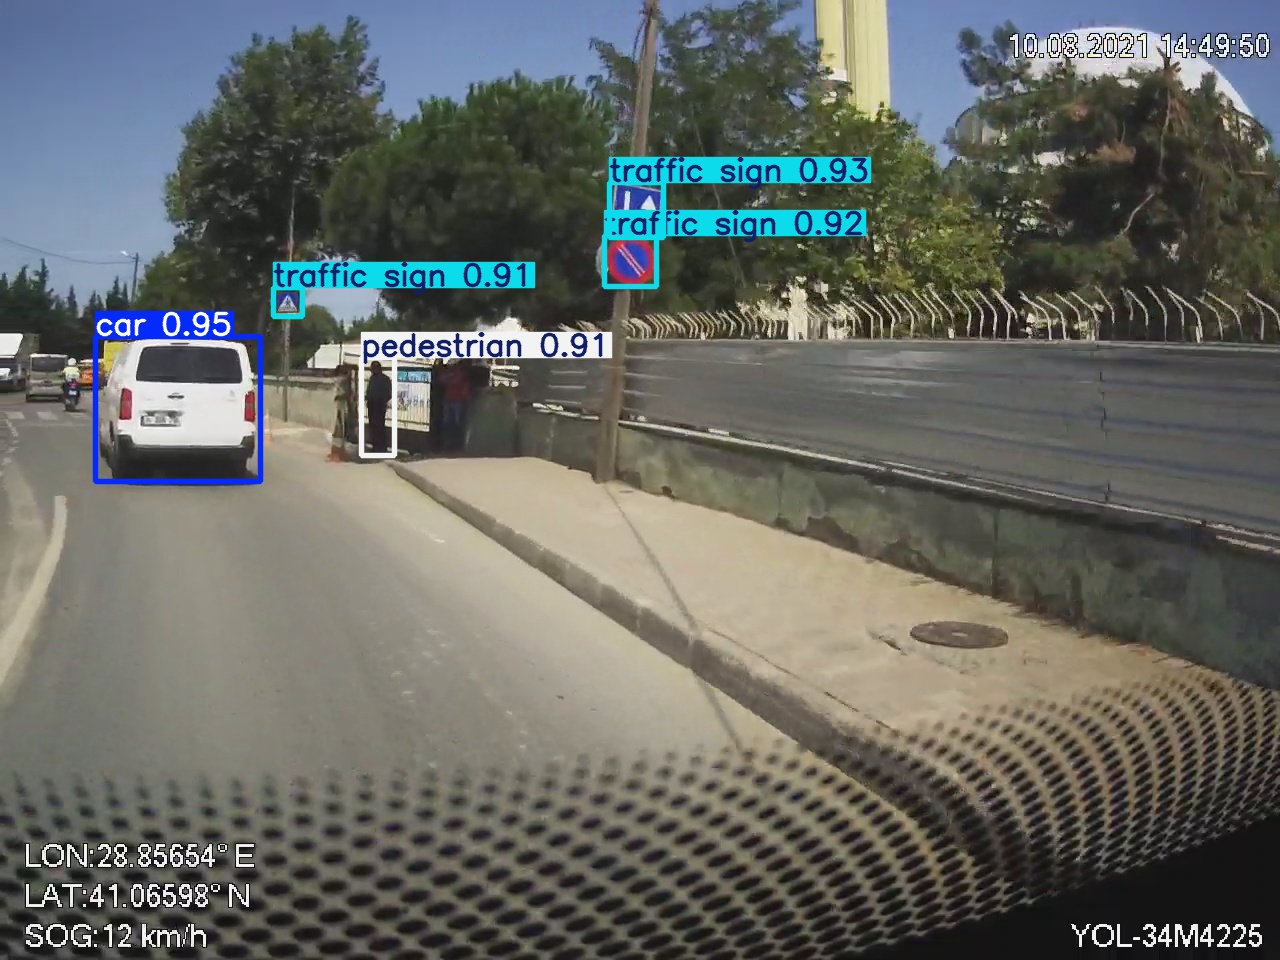

In [ ]:
import os
from IPython.display import Image, display

save_path = "/content/predict_results.jpg"

results[0].save(filename=save_path)

display(Image(filename=save_path))

# Train and Validation Loss Plots

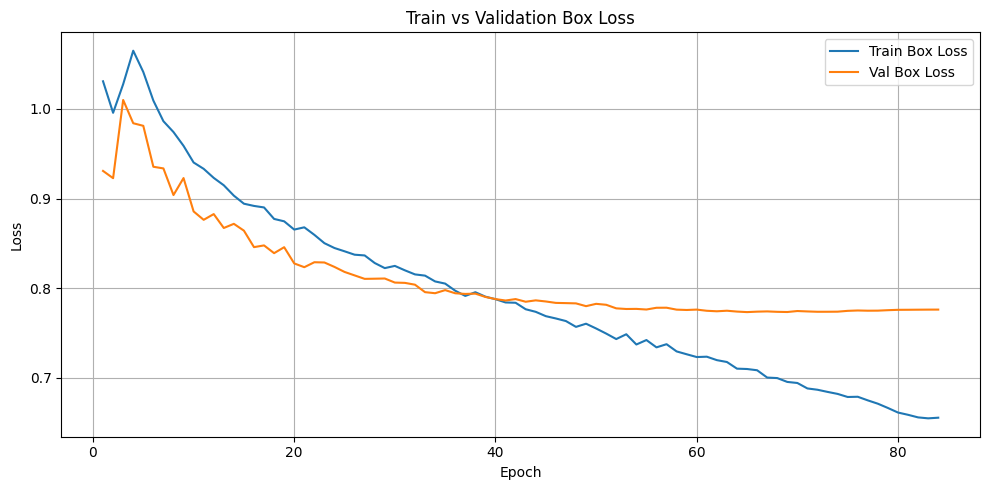

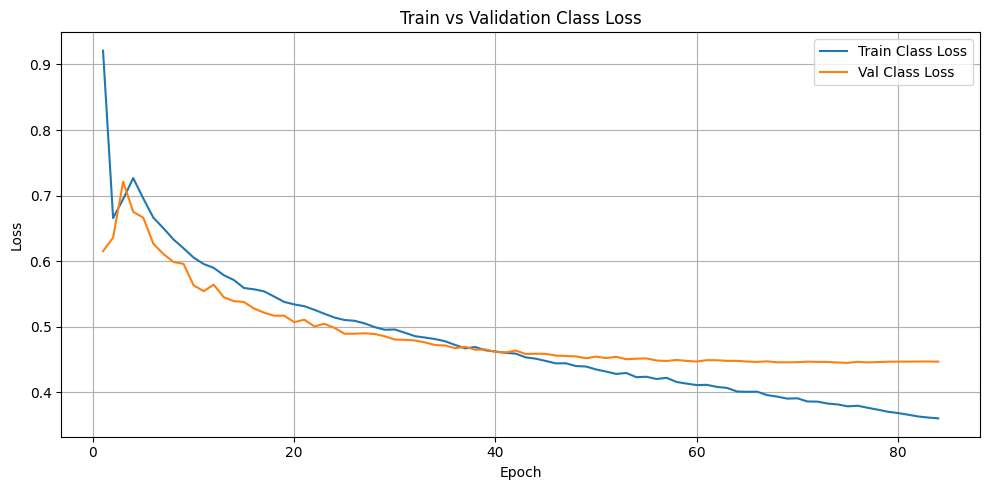

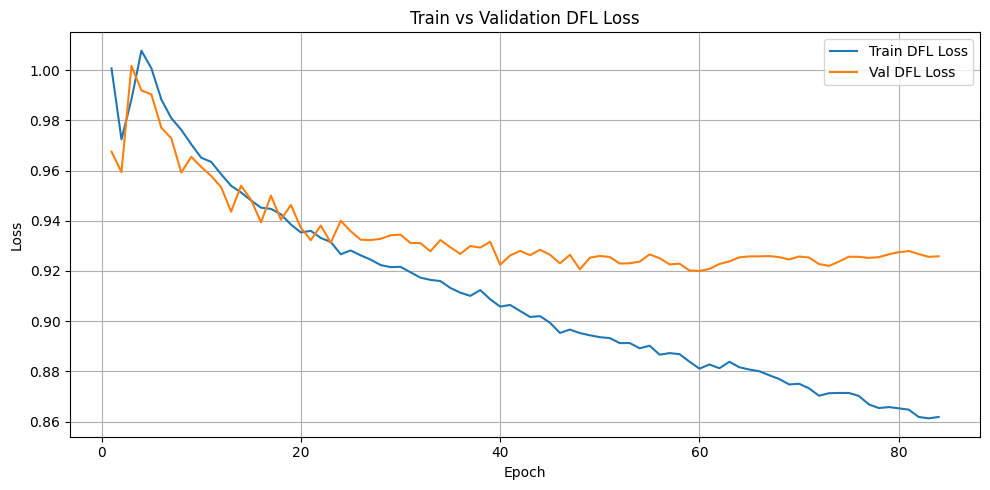

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results.csv")

loss_types = [
    ("box_loss", "Box Loss"),
    ("cls_loss", "Class Loss"),
    ("dfl_loss", "DFL Loss")
]

for loss_key, loss_label in loss_types:
    plt.figure(figsize=(10, 5))
    plt.plot(df["epoch"], df[f"train/{loss_key}"], label=f"Train {loss_label}")
    plt.plot(df["epoch"], df[f"val/{loss_key}"], label=f"Val {loss_label}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Train vs Validation {loss_label}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
